In [103]:
import pygor.load 
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def lowpass_filter(data, cutoff, fs, order=4):

    nyquist = 0.5 * fs  # Nyquist frequency is half the sampling rate
    normal_cutoff = cutoff / nyquist  # Normalize the cutoff frequency
    
    # Design the Butterworth filter
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    
    # Apply the filter to the data using filtfilt for zero-phase filtering
    filtered_data = filtfilt(b, a, data)
    
    return filtered_data

def flexible_reshape(array, columns):
    # Calculate the number of elements to keep
    elements_to_keep = (len(array) // columns) * columns
    # Reshape the array
    reshaped_array = array[:elements_to_keep].reshape(-1, columns)
    return reshaped_array

def cluster_correlation(trace):
        if len(trace)<=1:
            average_correlation = 0 
        
        else: 
            correlation_matrix = np.corrcoef(trace.transpose(), rowvar=False)
            n = correlation_matrix.shape[0]
            upper_triangular = correlation_matrix[np.triu_indices(n, k=1)]
            average_correlation = np.mean(upper_triangular)
        return average_correlation

def z_normalize_columns(data):

    # Calculate the mean and standard deviation for each column
    means = np.mean(data, axis=1)
    stds = np.std(data, axis=1)
    
    # Avoid division by zero in case any column has a standard deviation of zero
    stds[stds == 0] = 1
    
    # Z-normalize each column
    normalized_data = ((data.transpose() - means) / stds).transpose()
    
    return normalized_data

data_path = 'D:/Box Sync/Imaging/OT_singleplane/st53/'
export_path = 'C:/Users/Michael Forsthofer/OneDrive - University of Sussex/BadenLab/2p-imaging/singleplane/St53/'

In [104]:
filename = '2024-10-4_x241004_1_54_cOTs.h5'
depth = 350
ETL_surface = 1500
ETL_step=1
start_plane = 1
stimtypes = ['stationary stripes','moving stripes','stationary stripes','OFF','dots_ON','OFF','ON','dots_OFF','ON', 'ON', 'loom']
stimtypes_relevant = ['moving stripes', 'dots_ON', 'dots_OFF', 'loom']
#stimtypes = ['white', 'loom', 'left dot','right dot','down dot','up dot','left edge ON','left edge OFF','right edge ON','right edge OFF','bottom edge edge ON','bottom edge OFF','top edge ON','top edge OFF']
#stimtypes_relevant = ['loom','left dot','right dot','down dot','up dot']
data_object = pygor.load.Core(data_path+filename)

C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_22516\94617662.py:10: UserWarning: 2024-10-4_x241004_1_54_cOTs: Trigger mode 11 does not match phase number 1
  data_object = pygor.load.Core(data_path+filename)


In [105]:
if data_object.n_planes == 1:
    slices = np.array([depth])
else:
    slices = np.arange(0, (data_object.n_planes)*ETL_step, ETL_step)

def calc_roi_plane(roi_y, image_y, n_planes, slices_um, start_plane):
    plane_step = image_y/n_planes
    plane_bin = roi_y//plane_step
    corr_plane = int((plane_bin - (start_plane))%n_planes)
    return(slices_um[corr_plane])  


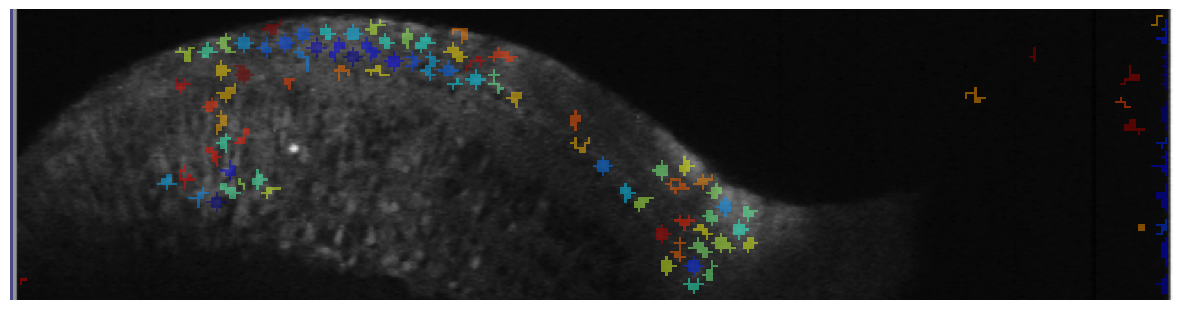

In [106]:
data_object.view_stack_rois(labels=False, figsize_scale=3, func='average_stack')

<b>Find where rois are located</b>

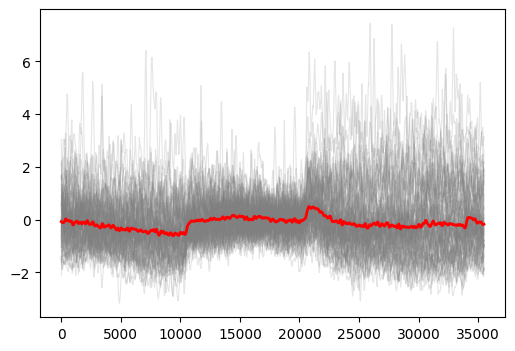

In [107]:
f1, ax1 = plt.subplots(1, 1, figsize=(6, 4))
#ax1.plot(data_object.averages.transpose(), color='grey', alpha=0.2, linewidth=0.5)

fs = 1/(data_object.frame_hz/(data_object.frame_hz/data_object.linedur_s))  # Sampling rate in Hz
cutoff = 1  # Cutoff frequency in Hz

# Apply the low-pass filter
#traces = lowpass_filter(data_object.averages, cutoff, fs)
traces = data_object.averages

plt.plot(traces.transpose(), color='grey', alpha=0.2, linewidth=0.8)
mean_roi_activity = np.mean(traces, axis=0)
plt.plot(mean_roi_activity, color='red', alpha=1, linewidth=2)

Cluster individual stimulus responses

In [108]:
triggertimes_ms = (data_object.triggerstimes_frame-data_object.triggerstimes_frame[0])/data_object.frame_hz/data_object.linedur_s*data_object.n_planes

mean_triggertimes_ms = flexible_reshape(triggertimes_ms, data_object.trigger_mode)
mean_triggertimes_ms = np.mean(mean_triggertimes_ms, axis=0)-np.mean(mean_triggertimes_ms, axis=0)[0]
mean_triggertimes_extended = np.round(np.append(mean_triggertimes_ms, len(traces.transpose()))).astype(int)
print('Triggers at ms:', mean_triggertimes_extended)

Triggers at ms: [    0  5069  7706 10240 15309 17997 20557 25600 28237 30771 32384 35486]


In [109]:
roi_y = []
roi_x = []
for i in range(len(data_object.averages)):
    i = (i+1)*-1
    r_y, r_x = np.where(data_object.rois == i)
    roi_y.append(np.mean(r_y))
    roi_x.append(np.mean(r_x))
roi_y = np.array(roi_y)
roi_x = np.array(roi_x)

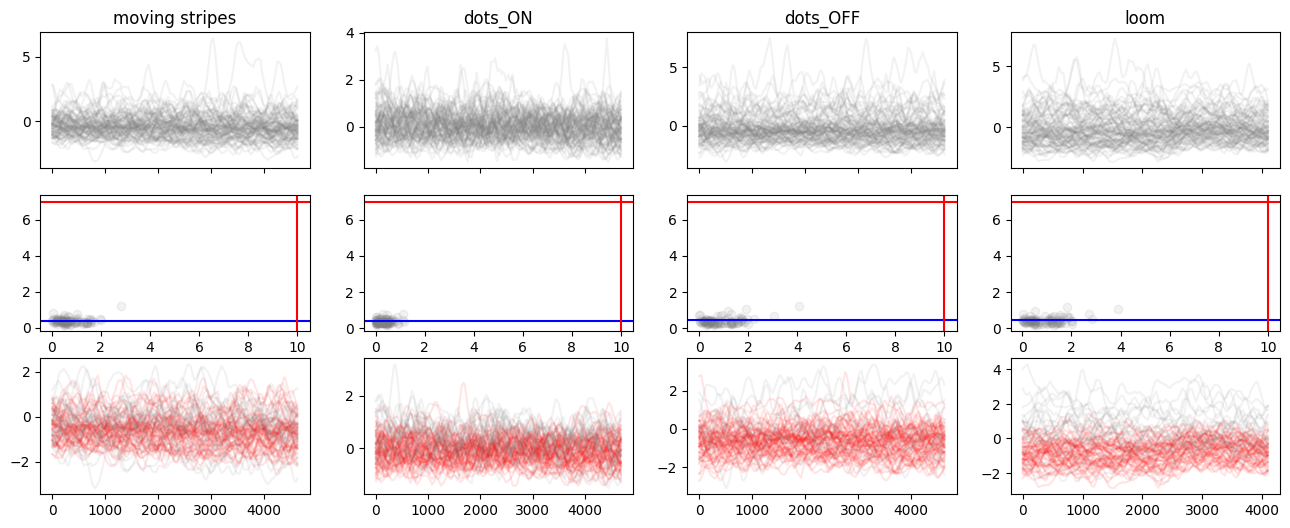

In [110]:
stim_responses = []
included_responses = []

append_idx = 1000
append_idx_post = 1000
SD_threshold = 1.2
roi_x_border = 400
downsample_factor = 100

#find stimulus segments plus some time before and after
for idx, i in enumerate(mean_triggertimes_extended[:-1]):
    if stimtypes[idx] in stimtypes_relevant:
        stim_responses.append(traces[:,i-append_idx:mean_triggertimes_extended[idx+1]+append_idx_post].transpose())  

#plot them
f, ax = plt.subplots(3, 4, figsize=(16, 6))
for idx, i in enumerate(stim_responses):
    ax[0, idx%4].plot(i, color='gray', alpha=0.1)  
    ax[0, idx%4].set_xticklabels([])
    ax[0, idx%4].set_title(stimtypes_relevant[idx])

#clean out non-responsive traces based on standard deviation filtering
responses_sorted = []
std_upper = 7
mean_lower = -1
mean_upper = 10
resting_mean_upper = 7
for idx, cur_traces in enumerate(stim_responses):
    trace_means = abs(np.mean(cur_traces, axis=0))
    trace_stds = abs(np.std(cur_traces, axis=0))
    prestim_SD = abs(np.std(cur_traces[0:append_idx,:], axis=0))
    std_lower = np.nanmean(prestim_SD)*SD_threshold
    prestim_max = np.max(cur_traces[0:append_idx,:], axis=0)


    
#plot mean vs SD to visualize, and plot the thresholds chosen
    ax[1, idx%4].plot(trace_means, trace_stds, 'o', color='gray', alpha=0.1)
    ax[1, idx%4].axhline(y=std_upper, color='red')
    ax[1, idx%4].axhline(y=std_lower, color='blue')
    ax[1, idx%4].axvline(x=mean_upper, color='red')
    ax[2, idx%4].plot(cur_traces[:, np.where(
        (trace_stds>std_upper) | 
        (trace_stds<std_lower) | 
        (prestim_max>resting_mean_upper)) [0]], color='red', alpha=0.1)  
 
    cutouts_sorted = cur_traces[:, np.where(
        (trace_stds<std_upper) & 
        (trace_stds>std_lower) & 
        (trace_means>mean_lower) & 
        (trace_means<mean_upper) & 
        (prestim_max<resting_mean_upper) & 
        (roi_x<roi_x_border)) [0]]
    ax[2, idx%4].plot(cutouts_sorted, color='gray', alpha=0.1) 
    #ax[2, idx%4].set_ylim(-1, 4)

    #responses_sorted.append(cutouts_sorted[::100,:].transpose())
    responses_sorted.append(cur_traces[::downsample_factor,:].transpose())
    included_responses.append(np.where(
        (trace_stds<std_upper) & 
        (trace_stds>std_lower) & 
        (trace_means>mean_lower) & 
        (trace_means<mean_upper) & 
        (prestim_max<resting_mean_upper)& 
        (roi_x<roi_x_border)) [0])

C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_22516\2706466949.py:22: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  cluster_linkage = linkage(euc_distances, method="complete")
C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_22516\2706466949.py:22: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  cluster_linkage = linkage(euc_distances, method="complete")
C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_22516\2706466949.py:22: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  cluster_linkage = linkage(euc_distances, method="complete")
C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_22516\2706466949.py:22: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance m

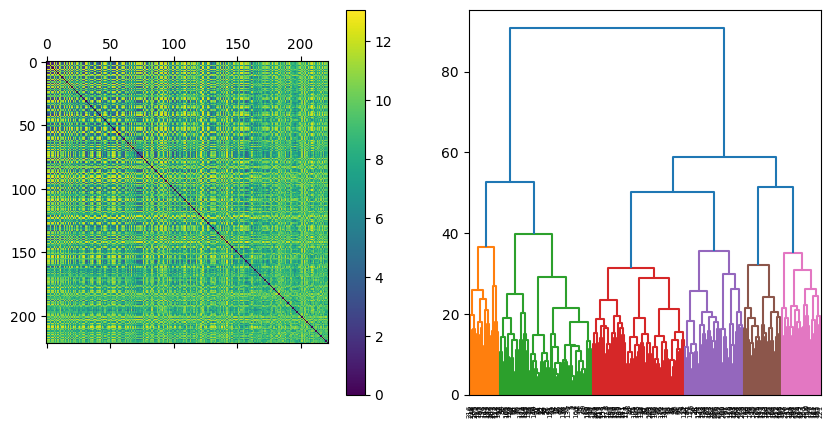

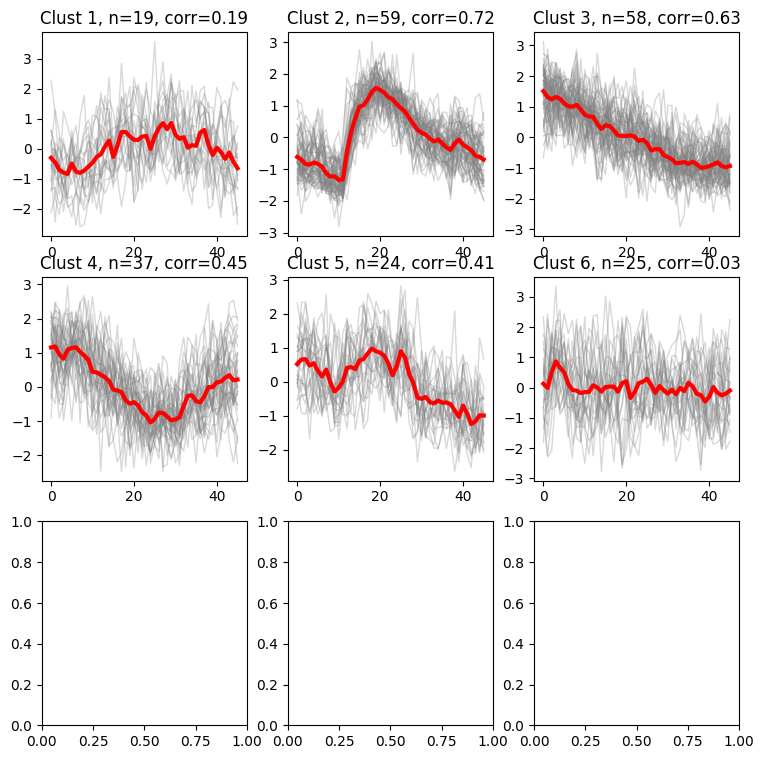

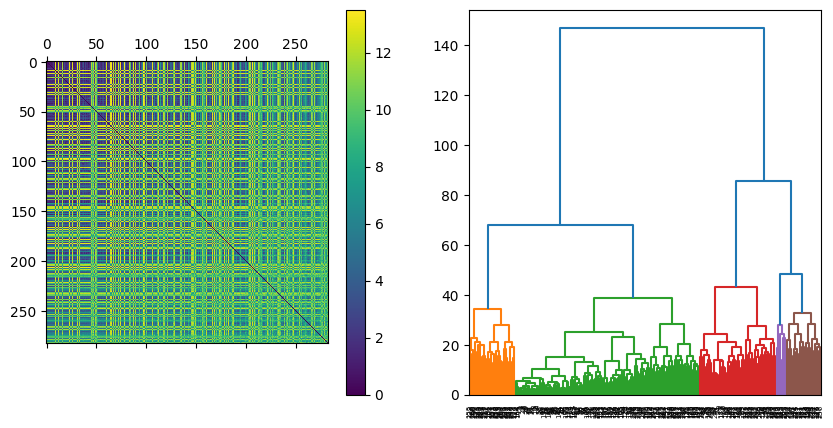

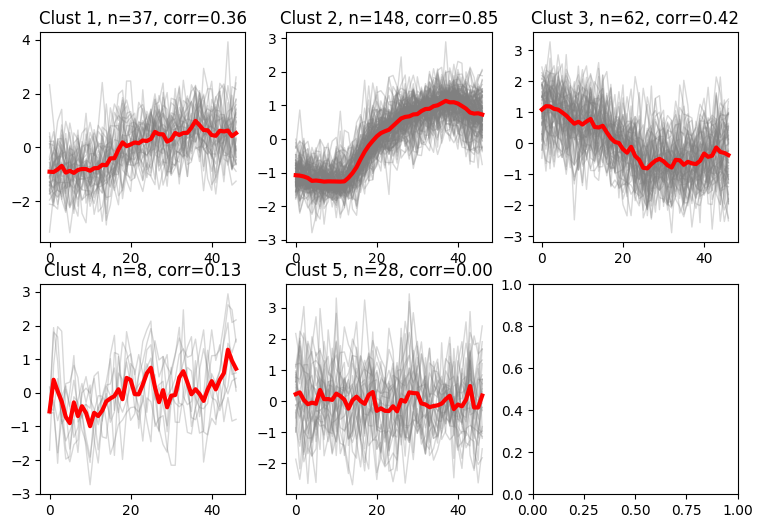

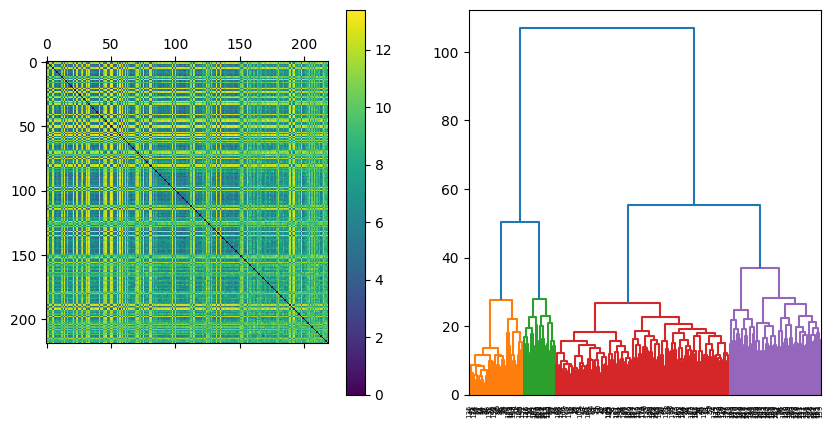

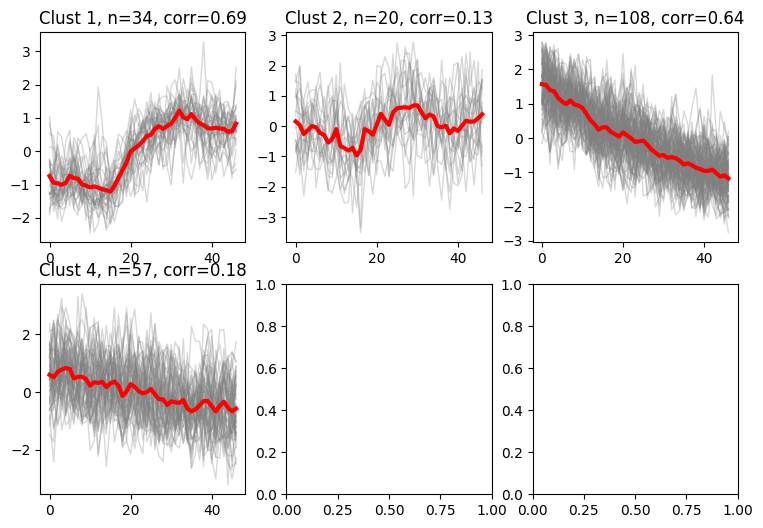

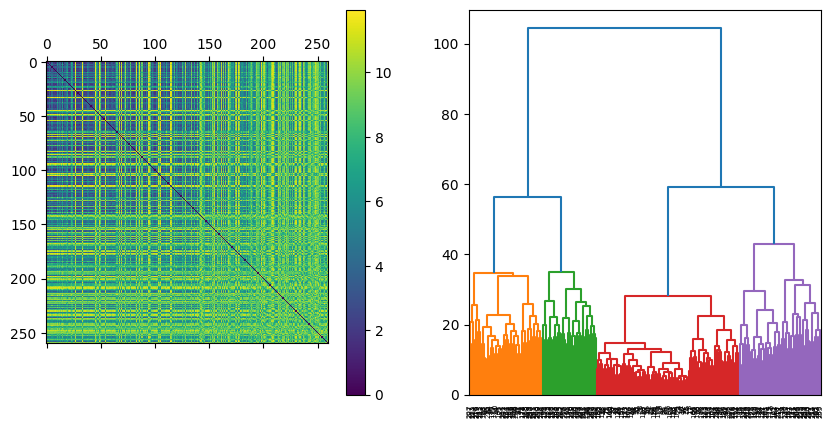

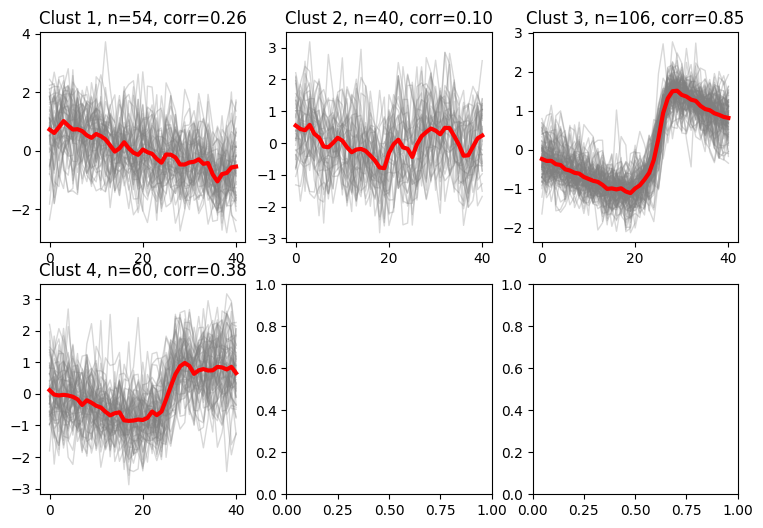

In [96]:
from sklearn.metrics import euclidean_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
cluster_threshold = 45

cluster_allocations = {}
cluster_traces = {}
cluster_correlations = {}
responding_rois = {}
for idx, cur_clust in enumerate(responses_sorted):
    cur_traces_raw = (cur_clust[included_responses[idx],:].transpose()-cur_clust[included_responses[idx],0]).transpose()

    #z-normalize traces
    cur_traces = z_normalize_columns(cur_traces_raw)
    euc_distances = euclidean_distances(cur_traces)

    # %% Visualize distance matrix
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    cax = ax[0].matshow(euc_distances)
    fig.colorbar(cax)

    cluster_linkage = linkage(euc_distances, method="complete")
    # %% plot dendrogram with indicated threshold
    dendrogram(cluster_linkage, ax=ax[1], color_threshold=cluster_threshold)

    # %% Cluster data based on distance matrix
    clustering = fcluster(
        cluster_linkage, criterion="distance", t=cluster_threshold)

    n_clusters = np.max(clustering) + 1
    n_cols = int(np.ceil(np.sqrt(n_clusters)))
    n_rows = int(np.ceil(n_clusters / n_cols))
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    ax = ax.flatten()

    cur_clust_trace = []
    cur_clust_correlation = []
    clust_rois = []
    for i in np.unique(clustering): 
        cur_correlation = cluster_correlation(cur_traces[clustering == i])
        ax[i-1].plot(cur_traces[clustering == i].transpose(), color='grey', alpha=0.3, linewidth=1)
        ax[i-1].plot(np.nanmean(cur_traces[clustering == i], axis=0), color='red', linewidth=3)
        #ax[i-1].set_xticks([])
        ax[i-1].set_title(f"Clust {i}, n={np.sum(clustering == i)}, corr={cur_correlation:.2f}" )
        cur_clust_trace.append(cur_traces_raw[clustering == i])
        cur_clust_correlation.append(cur_correlation)
        clust_rois.append(included_responses[idx][clustering == i])
    cluster_traces[stimtypes_relevant[idx]] = cur_clust_trace
    cluster_correlations[stimtypes_relevant[idx]] = cur_clust_correlation
    responding_rois[stimtypes_relevant[idx]] = clust_rois
    

    cluster_allocations[stimtypes_relevant[idx]] = clustering

In [97]:
def calc_tracestats(trace, prestim_dur_inds, samplerate_inds, resample_factor):
        prestim_dur = int(prestim_dur_inds/resample_factor)
        baseline = np.mean(trace[0:prestim_dur])
        trace_corrected = trace-baseline
        pk_loc = np.argmax(abs(trace_corrected))
        amplitude = trace_corrected[pk_loc]
        area = np.cumsum(trace_corrected)[-1]
        pk_latency = pk_loc*(samplerate_inds/resample_factor)
        return amplitude, area, pk_latency


skipped moving stripes cluster 0, correlation too low
stim not in list
skipped moving stripes cluster 2, correlation too low
skipped moving stripes cluster 3, correlation too low
skipped moving stripes cluster 4, correlation too low
skipped moving stripes cluster 5, correlation too low
skipped dots_ON cluster 0, correlation too low
stim not in list
skipped dots_ON cluster 2, correlation too low
skipped dots_ON cluster 3, correlation too low
skipped dots_ON cluster 4, correlation too low
stim not in list
skipped dots_OFF cluster 1, correlation too low
skipped dots_OFF cluster 2, correlation too low
skipped dots_OFF cluster 3, correlation too low
skipped loom cluster 0, correlation too low
skipped loom cluster 1, correlation too low
stim not in list
skipped loom cluster 3, correlation too low


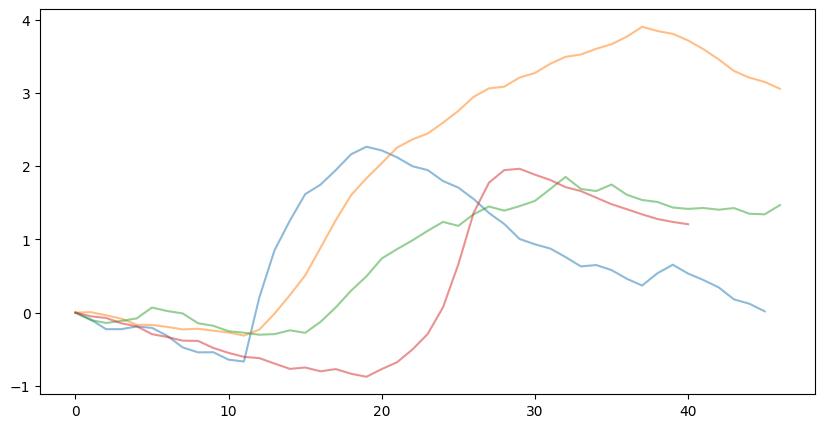

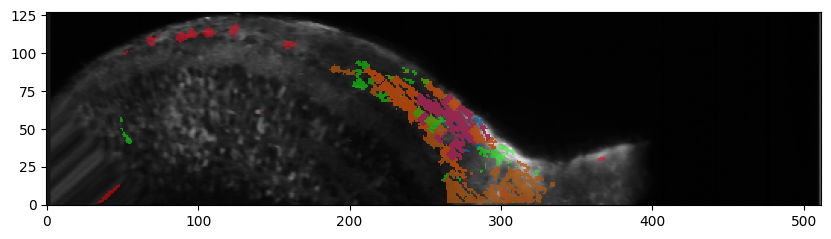

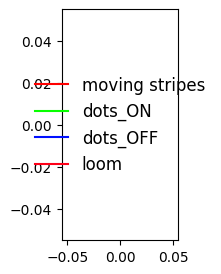

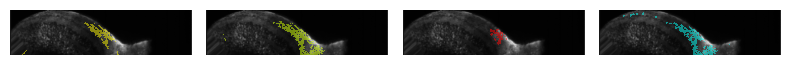

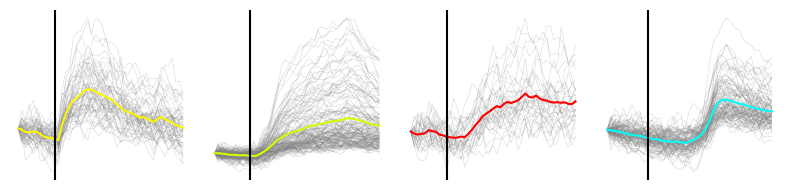

In [98]:
min_traces_per_cluster = 6
correlation_threshold = 0.68

roi_indices_export = {}
roi_depth_export = {}
roi_size_export = {}
roi_amplitude_export = {}
roi_area_export = {}
roi_latency_export = {}
roi_xy_export = {}
roi_centroid_x_export = {}
roi_centroid_y_export = {}
roi_plane_export = {}
roi_cluster_allocation_export = {}
roi_metadata_export = {'SD_threshold':SD_threshold, 
                       'correlation_threshold':correlation_threshold, 
                       'min_traces_per_cluster':min_traces_per_cluster, 
                       'cluster_threshold':cluster_threshold,
                       'depth': depth,
                       'stage' : 53}

#set up plot color parameters
stimuli_to_plot = ['moving stripes', 'dots_ON', 'dots_OFF', 'loom']
n_traces = np.zeros(len(stimuli_to_plot))
colors = plt.get_cmap('hsv')(np.linspace(0, 1, len(stimtypes_relevant)))
clustcolors = plt.get_cmap('hsv')(np.linspace(0, 1, 10))
f, ax = plt.subplots(1, 1, figsize=(10, 5))
f2, ax2 = plt.subplots(1, 1, figsize=(10, 10))
f3, ax3 = plt.subplots(1, 1, figsize=(1.5, 3))
f4, ax4 = plt.subplots(1, len(stimuli_to_plot), figsize=(8,16))
f5, ax5 = plt.subplots(1, len(stimuli_to_plot), figsize=(8,2))

#pre-plot the SD projection image
for background_image in range(len(stimuli_to_plot)):
    ax4[background_image].imshow(data_object.average_stack, cmap="Greys_r", origin="lower")
ax2.imshow(data_object.average_stack, cmap="Greys_r", origin="lower")
handles_labels = {}
stim_responsive_clusters = []

ipl_depths = {}
ipl_depths_area_amplitudecorrected = {}


#iterate through each stimtype and cluster
for stim_idx, cur_stim in enumerate(stimtypes_relevant):
    clustcolors = plt.get_cmap('hsv')(np.linspace(0, 1, np.max(cluster_allocations[cur_stim])+1))
    found_depths = np.array([])
    found_depths_areacorrected = np.array([])
    found_depths_area_amplitudecorrected = np.array([])

    cluster_indices_export = []
    cluster_depth_export = []
    plane_depths_export = []
    cluster_size_export = []
    cluster_amplitude_export = []
    cluster_area_export = []
    cluster_latency_export = []
    cluster_xy_export = []
    roi_indices_export[cur_stim] = []
    cluster_centroid_x_export = []
    cluster_centroid_y_export = []
    cluster_depths_export = []
    cur_cluster_allocation_export = []
    for idx, cur_cluster in enumerate(cluster_traces[cur_stim]):
        
        #check if cluster has enough traces
        if len(cur_cluster) < min_traces_per_cluster:
            print(f'skipped {cur_stim} cluster {idx}, not enough traces')
            continue
        
        #check if cluster has correlation above threshold
        if cluster_correlations[cur_stim][idx] <= correlation_threshold:
            print(f'skipped {cur_stim} cluster {idx}, correlation too low')
            continue

        found_rois = (responding_rois[cur_stim][idx]+1)*-1
        found_depths = data_object.ipl_depths[responding_rois[cur_stim][idx]]

        sizes = np.array([])
        amps = np.array([])
        areas = np.array([])
        latencies = np.array([])
        cur_centroid_x = np.array([])
        cur_centroid_y = np.array([])
        cur_plane_depth = np.array([])
        cur_cluster_allocation = np.array([])

        for cur_roi in responding_rois[cur_stim][idx]:
            roi_size =len(np.where(data_object.rois==(cur_roi+1)*-1)[0])
            cur_roi_depth = data_object.ipl_depths[cur_roi]
            roi_amplitude, roi_activity_area, roi_maxlatency = calc_tracestats(responses_sorted[stim_idx][cur_roi], append_idx, fs, downsample_factor)
            found_depths_area_amplitudecorrected = np.hstack([found_depths_area_amplitudecorrected, np.repeat(cur_roi_depth, roi_size+round(roi_amplitude))])
            sizes = np.append(sizes, roi_size)
            amps = np.append(amps, roi_amplitude)
            areas = np.append(areas, roi_activity_area)
            latencies = np.append(latencies, roi_maxlatency)
            cur_centroid_x = np.append(cur_centroid_x, np.mean(np.where(data_object.rois==(cur_roi+1)*-1)[1]))
            cur_centroid_y = np.append(cur_centroid_y, np.mean(np.where(data_object.rois==(cur_roi+1)*-1)[0]))
            cur_plane_depth = np.append(cur_plane_depth, calc_roi_plane(cur_centroid_y[-1], data_object.average_stack.shape[0], data_object.n_planes, slices, start_plane))
            cur_cluster_allocation = np.append(cur_cluster_allocation, idx=1)
        plane_depths_export.append(cur_plane_depth)
        cluster_size_export.append(sizes)
        cluster_amplitude_export.append(amps)
        cluster_area_export.append(areas)
        cluster_latency_export.append(latencies)
        cluster_centroid_x_export.append(cur_centroid_x)
        cluster_centroid_y_export.append(cur_centroid_y)
        cur_cluster_allocation_export.append(cur_cluster_allocation)
        
        #found_rois = (np.where(cluster_allocations[cur_stim] == idx+1)[0]) * -1
        mask = np.isin(data_object.rois, found_rois)
        ax.plot(np.nanmean(cur_cluster, axis=0), alpha=0.5)

                         # Create a colored overlay where only the mask part is colored
        color = colors[stim_idx]  # Select the color for the current idx_stim
        clustcolor=clustcolors[idx]
        colored_mask = np.zeros((*mask.shape, 4))  # Create an RGBA image (shape + 4 for RGBA)
        clust_mask = np.zeros((*mask.shape, 4))
        if stim_idx not in handles_labels:
            ax3.plot(0, 0, color=color, label=stimtypes_relevant[stim_idx])
            handles_labels[stim_idx] = f'Stim {stim_idx}'  # Track the label
                        
        # Apply color only to the ROI parts of the mask
        colored_mask[mask] = np.array([*color[:3], 0.5])  # Use the RGB values from the colormap and set alpha to 0.5
        clust_mask[mask] = np.array([*clustcolor[:3], 0.5])  # Use the RGB values from the colormap and set alpha to 0.5

        cluster_indices_export.append(found_rois)
        cluster_depth_export.append(found_depths)
        cluster_xy_export.append(np.where(mask))

        # Plot the colored mask over the background
        ax2.imshow(colored_mask, interpolation='none', origin="lower")
        try:
            index_of_dots_ON = stimuli_to_plot.index(stimtypes_relevant[stim_idx])
            ax4[index_of_dots_ON].imshow(clust_mask, interpolation='none', origin="lower")
            ax4[index_of_dots_ON].axis('off')
            ax5[index_of_dots_ON].plot(cur_cluster.transpose()-cur_cluster[:,0].transpose(), color='grey', alpha=0.3, linewidth=0.4)
            ax5[index_of_dots_ON].plot(np.nanmean(cur_cluster, axis=0)-np.nanmean(cur_cluster, axis=0)[0], color=clustcolor, linewidth=1.5)
            ax5[index_of_dots_ON].axvline(append_idx/downsample_factor, color='k')
            ax5[index_of_dots_ON].axis('off')
                            #ax4[index_of_dots_ON, 1].set_ylim([-6, 15])
                            #ax4[index_of_dots_ON, 1].set_xlim([0, 2600])
            n_traces[index_of_dots_ON] = n_traces[index_of_dots_ON] + len(stim_responses[idx_stim][cur_label_array == cur_label,:].transpose())
        except:
            print('stim not in list')
    roi_indices_export[cur_stim] = cluster_indices_export
    roi_depth_export[cur_stim] = cluster_depth_export
    roi_size_export[cur_stim] = cluster_size_export
    roi_amplitude_export[cur_stim] = cluster_amplitude_export
    roi_area_export[cur_stim] = cluster_area_export
    roi_latency_export[cur_stim] = cluster_latency_export
    roi_xy_export[cur_stim] = cluster_xy_export
    roi_centroid_x_export[cur_stim] = cluster_centroid_x_export
    roi_centroid_y_export[cur_stim] = cluster_centroid_y_export
    roi_plane_export[cur_stim] = plane_depths_export
    ipl_depths[cur_stim] = found_depths
    ipl_depths_area_amplitudecorrected[cur_stim] = found_depths_area_amplitudecorrected
    roi_cluster_allocation_export[cur_stim] = cur_cluster_allocation_export
f4.tight_layout()
f5.tight_layout()
ax3.legend(loc='center', bbox_to_anchor=(0.5, 0.5), fontsize=12, ncol=1, frameon=False)

f4.savefig(export_path+filename+'roiclusters.svg')
f5.savefig(export_path+filename+'clustertraces.svg')



(54500.0, 54900.0)

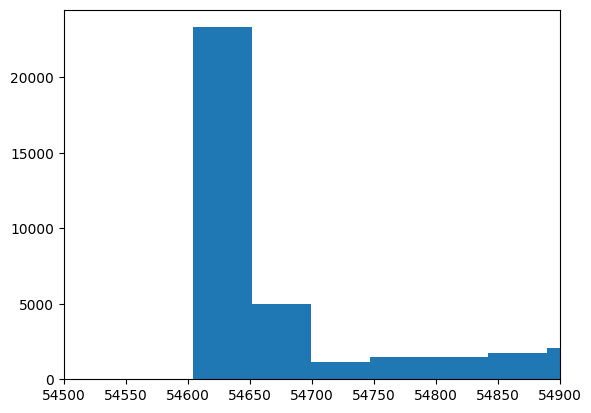

In [99]:
plt.hist(data_object.average_stack.flatten(), bins=100)
plt.xlim(54500, 54900)

[Text(0, 0, 'moving stripes'), Text(1, 0, 'dots_ON'), Text(2, 0, 'dots_OFF')]

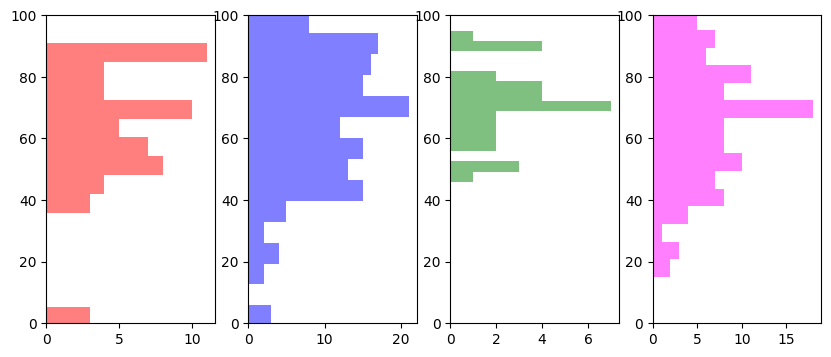

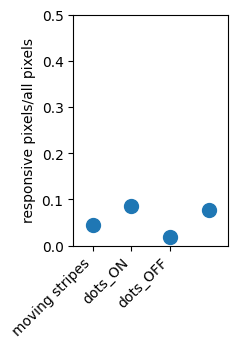

In [100]:
dark_threshold = 54700

#area of rois:
#imaging_area = len(np.where(data_object.rois<0)[0])

#area of brain:
imaging_area = len(np.where(data_object.average_stack.flatten()>dark_threshold)[0])
xlim_max = 25
f, ax = plt.subplots(1,4, figsize=(10, 4))
ax[0].hist(ipl_depths['moving stripes'], histtype='stepfilled', bins=15, alpha=0.5, orientation="horizontal", density=False, color='red')
ax[0].set_ylim([0, 100])
ax[1].hist(ipl_depths['dots_ON'], histtype='stepfilled', bins=15, alpha=0.5, orientation="horizontal", density=False, color='blue')
ax[1].set_ylim([0, 100])
ax[2].hist(ipl_depths['dots_OFF'], histtype='stepfilled', bins=15, alpha=0.5, orientation="horizontal", density=False, color='green')
ax[2].set_ylim([0, 100])
ax[3].hist(ipl_depths['loom'], histtype='stepfilled', bins=15, alpha=0.5, orientation="horizontal", density=False, color='magenta')
ax[3].set_ylim([0, 100])

stimtypes = ['moving stripes', 'dots_ON', 'dots_OFF']
f2, ax2 = plt.subplots(figsize = (2, 3))
responsive_area_size = [np.sum([np.sum(arr) for arr in roi_size_export['moving stripes']])/imaging_area, 
                        np.sum([np.sum(arr) for arr in roi_size_export['dots_ON']])/imaging_area, 
                        np.sum([np.sum(arr) for arr in roi_size_export['dots_OFF']])/imaging_area,
                        np.sum([np.sum(arr) for arr in roi_size_export['loom']])/imaging_area]

ax2.plot(responsive_area_size, 'o', markersize=10)
#fig = px.scatter(y=responsive_area_size)
ax2.set_xlim(-.5, 3.5)
ax2.set_ylim(0, 0.5)
ax2.set_ylabel('responsive pixels/all pixels')
ax2.set_xticks([0, 1, 2])  # Position the ticks
ax2.set_xticklabels(stimtypes, rotation=45, ha='right')  # Replace with custom labels and rotate


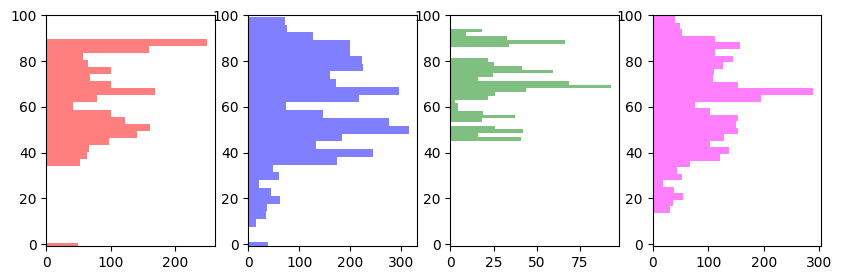

In [101]:
from scipy.signal import savgol_filter

# Parameters
xlim_max = 25
bins = 30

# Create subplots
f, ax = plt.subplots(1, 4, figsize=(10, 3))

# Data and histogram for "moving stripes"
hist_moving_stripes, bin_edges_moving_stripes = np.histogram(ipl_depths_area_amplitudecorrected['moving stripes'], bins=bins, density=False)
smoothed_moving_stripes = savgol_filter(hist_moving_stripes, window_length=2, polyorder=1)
ax[0].barh(bin_edges_moving_stripes[:-1], smoothed_moving_stripes, height=np.diff(bin_edges_moving_stripes), color='red', alpha=0.5)

# Data and histogram for "dots_ON"
hist_dots_ON, bin_edges_dots_ON = np.histogram(ipl_depths_area_amplitudecorrected['dots_ON'], bins=bins, density=False)
smoothed_dots_ON = savgol_filter(hist_dots_ON, window_length=2, polyorder=1)
ax[1].barh(bin_edges_dots_ON[:-1], smoothed_dots_ON, height=np.diff(bin_edges_dots_ON), color='blue', alpha=0.5)


# Data and histogram for "dots_OFF"
hist_dots_OFF, bin_edges_dots_OFF = np.histogram(ipl_depths_area_amplitudecorrected['dots_OFF'], bins=bins, density=False)
smoothed_dots_OFF = savgol_filter(hist_dots_OFF, window_length=2, polyorder=1)
ax[2].barh(bin_edges_dots_OFF[:-1], smoothed_dots_OFF, height=np.diff(bin_edges_dots_OFF), color='green', alpha=0.5)

hist_loom, bin_loom = np.histogram(ipl_depths_area_amplitudecorrected['loom'], bins=bins, density=False)
smoothed_loom = savgol_filter(hist_loom, window_length=2, polyorder=1)
ax[3].barh(bin_loom[:-1], smoothed_loom, height=np.diff(bin_loom), color='magenta', alpha=0.5)


ax[0].set_ylim([-1, 100])
ax[1].set_ylim([-1, 100])
ax[2].set_ylim([-1, 100])
ax[3].set_ylim([-1, 100])

f. savefig(export_path+filename+'_depths.png', dpi=300)


In [102]:
import pickle
extracted_data = {'indices' : roi_indices_export, 
                  'depths' : roi_depth_export,
                  'sizes' : roi_size_export,
                  'amplitudes' : roi_amplitude_export,
                  'xy_coords' : roi_xy_export,
                  'x_centroid' : roi_centroid_x_export,
                  'y_centroid' : roi_centroid_y_export,
                  'plane_depth' : roi_plane_export,
                  'activity_area' : roi_area_export,
                  'latency' : roi_latency_export,
                  'metadata' : roi_metadata_export}

with open(export_path+filename+'_processed.pkl', 'wb') as f:
    pickle.dump(extracted_data, f)